In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
#
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# from tqdm.notebook import tqdm
from tqdm import tqdm
tqdm.pandas()

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
%ls /kaggle

input/  lib/  src/  working/


In [3]:
train_data = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
test_data  = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')
train_data.shape, test_data.shape

((12120, 6), (5195, 5))

In [4]:
train_data.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


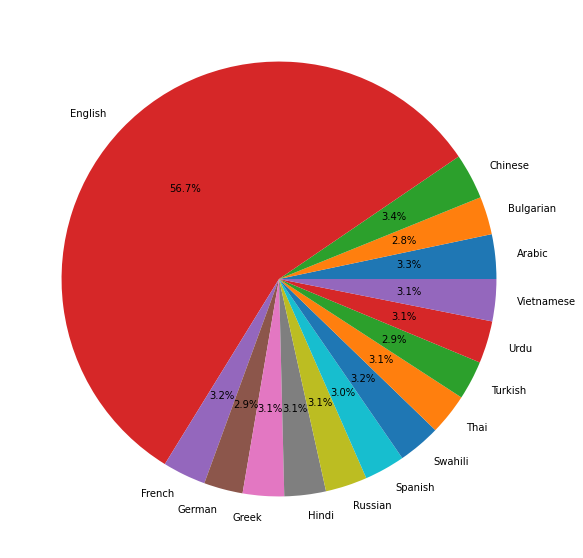

In [5]:
labels, frequencies = np.unique(train_data.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

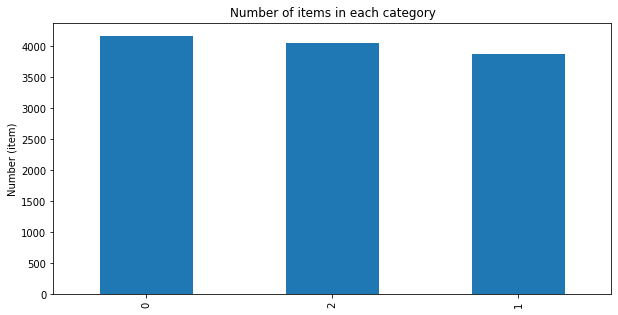

In [6]:
labels = train_data.label.value_counts()
plt.figure(figsize = (10,5))
labels.plot.bar()
plt.title("Number of items in each category")
plt.ylabel("Number (item)")
plt.show()

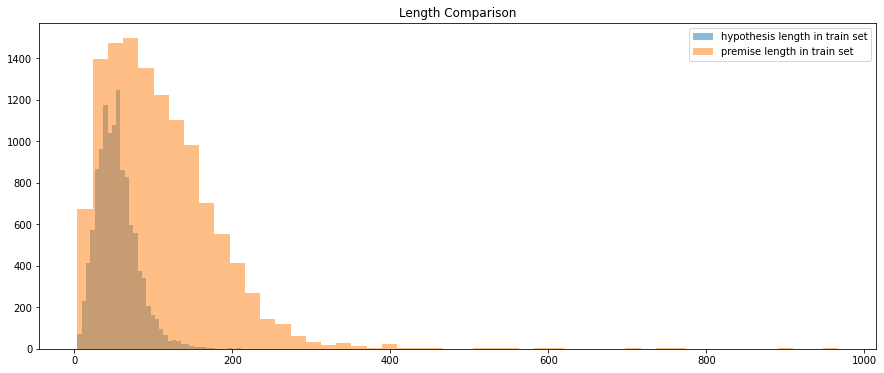

In [7]:
## Comparing length of sentences in train_set
hypo_len = train_data['hypothesis'].apply(len)
prem_len = train_data['premise'].apply(len)

plt.figure(figsize=(15,6))
plt.hist(hypo_len, bins=50, label="hypothesis length in train set", alpha=0.5)
plt.hist(prem_len, bins=50, label="premise length in train set", alpha=0.5)
plt.title("Length Comparison")
plt.legend(loc='best')
plt.show()

In [8]:
!pip install transformers
!pip install sentencepiece

In [9]:
# TensorFlow
import tensorflow as tf

# SKLearn Library
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [10]:
# Troncate Premises & Hypothesis sequences at max_len
max_len=64

# Loading Data Into TensorFlow Dataset
AUTO = tf.data.experimental.AUTOTUNE
batch_size = 16

In [11]:
def troncate_sentence(sent, seq_len=max_len):
    """" Return troncated sentence up to seq_len """
    try:
        sent = sent.split()
        sent = sent[:seq_len]
        return " ".join(sent)
    except:
        return sent

def generate_tokens(df, tokenizer, seq_len=2*max_len):
    """" Return list of token input_ids for a given dataframe"""
    input_ids = []
    input_masks = []
    
    for i, text in tqdm(enumerate(df.values.tolist()), total=len(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=seq_len, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            # return_tensors='tf'
        )
    
        input_ids.append(tokenized_text['input_ids'])
        input_masks.append(tokenized_text['attention_mask'])
    return input_ids, input_masks

def get_body_encoding(hypothesis, premises, tokenizer):
    """" Return encoded body from hyp and prem  """
    body = hypothesis.apply(troncate_sentence) + "[SEP]" + premises.apply(troncate_sentence)
    return generate_tokens(body, tokenizer)

## On applique une des variantes du modèle pré-entraîné multilingue `XLMRoberta` 

In [12]:
# Transformer Model
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel

# Transformer Model Name
transformer_model = 'jplu/tf-xlm-roberta-large' 
# 'joeddav/xlm-roberta-large-xnli' --> Nowadays, this model is privates but gives better performance than used : 'jplu/tf-xlm-roberta-large' 

# Define Tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(transformer_model)

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

In [13]:
# print(generate_tokens(pd.Series(["The rules developed in the interim"]), tokenizer=tokenizer))

In [14]:
#Pretrained Transformer Model
transformer_encoder = TFXLMRobertaModel.from_pretrained(transformer_model)

Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.27G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [15]:
# Build model function
def build_model(transformer, final_len=2*max_len, learnin_rate=2e-6):
    # Input
    # input_layer = tf.keras.layers.Input(shape=(final_len,), dtype=tf.int32, name="input_layer")
    input_ids = tf.keras.layers.Input(shape=(final_len,), name='input_ids', dtype='int32')
    input_masks = tf.keras.layers.Input(shape=(final_len,), name='attention_mask', dtype='int32')

    # Sequence output
    sequence_output = transformer(input_ids, attention_mask=input_masks)[0]
    cls_token = sequence_output[:, 0, :]
    cls_token = tf.keras.layers.Dropout(0.3)(cls_token)
    cls_token = tf.keras.layers.Dense(64, activation='relu')(cls_token)
    # Output Layers
    output_layer = tf.keras.layers.Dense(3, activation='softmax')(cls_token)
    # Model graph
    model = tf.keras.models.Model(inputs=[input_ids, input_masks], outputs=output_layer)
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learnin_rate), 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
    )
    return model

In [16]:
# Split into Training (90%) & Validation (10%)
x_train, x_val, y_train, y_val = train_test_split(
    train_data[['premise','hypothesis']], 
    train_data.label.values, 
    test_size=0.1,
    random_state=42,
)
# Prepare inputs
# Training set
train_input_ids, train_attn_masks = get_body_encoding(
    x_train['hypothesis'],
    x_train['premise'],
    tokenizer=tokenizer
)
train_ds = tf.data.Dataset.from_tensor_slices((train_input_ids, train_attn_masks, y_train)).repeat().shuffle(2048).batch(batch_size).prefetch(AUTO)
# Validation set
valid_input_ids, valid_attn_masks = get_body_encoding(
    x_val['hypothesis'],
    x_val['premise'],
    tokenizer=tokenizer
)
val_ds = tf.data.Dataset.from_tensor_slices((valid_input_ids, valid_attn_masks, y_val)).batch(batch_size).prefetch(AUTO)

100%|██████████| 1212/1212 [00:00<00:00, 3452.35it/s]


In [17]:
def map_func(input_ids, masks, labels):
    # we convert our three-items tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
train_ds = train_ds.map(map_func)
val_ds = val_ds.map(map_func)

In [18]:
# Application to xlm_roberta
xlm_model = build_model(transformer = transformer_encoder)
# Model Summary
xlm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 1024)         0           tfxlm_roberta_model[0][0]    

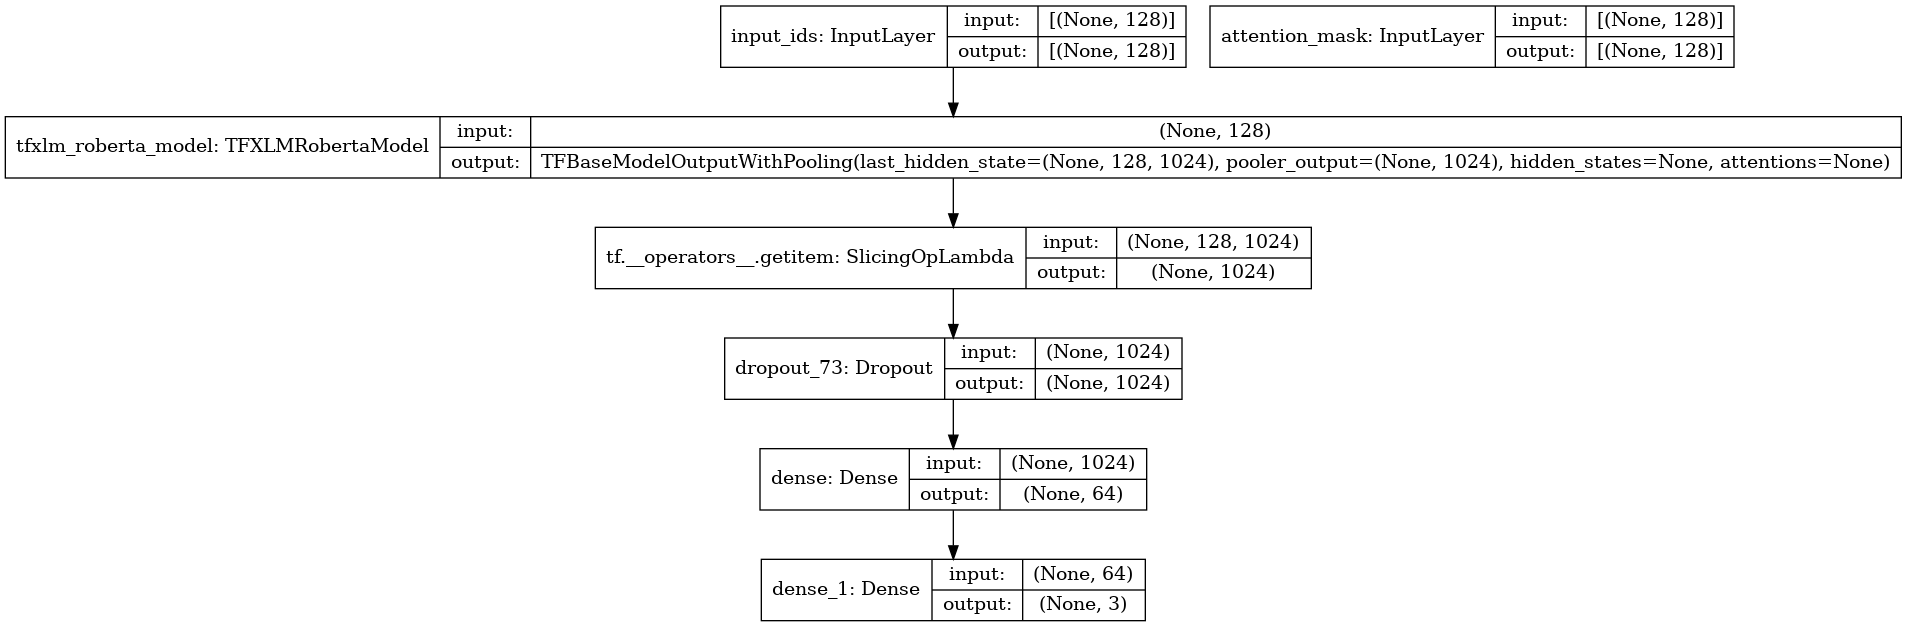

In [19]:
tf.keras.utils.plot_model(xlm_model, show_shapes=True)

In [20]:
# callbacks
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=1,
    restore_best_weights=True
)

# On-the-fly data augmentation
n_steps = len(train_data) // batch_size 

# Train the Model
hist_xlm = xlm_model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = 10,
    steps_per_epoch = n_steps,
    callbacks=[stop_early],
#    batch_size = 32,
)

Epoch 1/10
757/757 [==============================] - 715s 905ms/step - loss: 1.1508 - accuracy: 0.3356 - val_loss: 1.1018 - val_accuracy: 0.3663
Epoch 2/10
757/757 [==============================] - 680s 898ms/step - loss: 1.0519 - accuracy: 0.4288 - val_loss: 0.6428 - val_accuracy: 0.7294
Epoch 3/10
757/757 [==============================] - 680s 899ms/step - loss: 0.6395 - accuracy: 0.7381 - val_loss: 0.5682 - val_accuracy: 0.7830
Epoch 4/10
757/757 [==============================] - 681s 899ms/step - loss: 0.4842 - accuracy: 0.8111 - val_loss: 0.5630 - val_accuracy: 0.8045
Epoch 5/10
757/757 [==============================] - 680s 899ms/step - loss: 0.4185 - accuracy: 0.8438 - val_loss: 0.5916 - val_accuracy: 0.8177


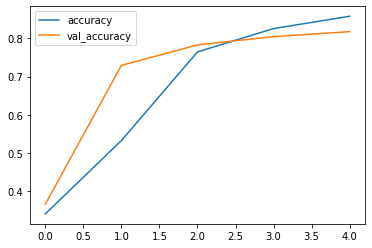

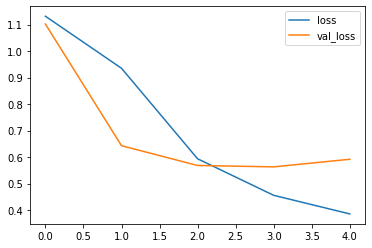

In [21]:
pd.DataFrame(hist_xlm.history).loc[:, ["accuracy", "val_accuracy"]].plot()
pd.DataFrame(hist_xlm.history).loc[:, ["loss", "val_loss"]].plot()
plt.show()

In [22]:
# Evaluate on Validation Set
xlm_model.evaluate(val_ds)

76/76 [==============================] - 22s 291ms/step - loss: 0.5630 - accuracy: 0.8045


[0.5629530549049377, 0.8044554591178894]

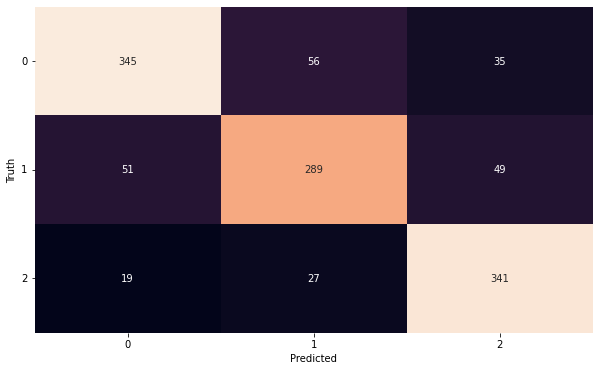

In [23]:
# Get predicted labels
y_pred = xlm_model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

# Construction of cm
cm = confusion_matrix(y_val, y_pred)
# Plot
plt.figure(figsize=(10,6))
c = sns.heatmap(cm, annot=True, fmt='g', cbar=False)
c.set_xlabel('Predicted')
c.set_ylabel('Truth')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

In [24]:
pd.DataFrame(classification_report(
    y_val,
    y_pred,
    output_dict=True,
    zero_division=0
)).T

,precision,recall,f1-score,support
0,0.831325,0.791284,0.810811,436.000000
1,0.776882,0.742931,0.759527,389.000000
2,0.802353,0.881137,0.839901,387.000000
accuracy,0.804455,0.804455,0.804455,0.804455
macro avg,0.803520,0.805117,0.803413,1212.000000
weighted avg,0.804600,0.804455,0.803640,1212.000000


# Submission

In [25]:
# del test_ds
def map_func_test(input_ids, masks):
    # we convert our two-items tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}

In [26]:
test_input_ids, test_attn_masks = get_body_encoding(
    test_data['hypothesis'],
    test_data['premise'],
    tokenizer=tokenizer
)
test_ds = tf.data.Dataset.from_tensor_slices((test_input_ids, test_attn_masks)).batch(batch_size).prefetch(AUTO)
test_ds = test_ds.map(map_func_test)
#test_ds = (tf.data.Dataset.from_tensor_slices((test_encode)).batch(batch_size).prefetch(AUTO))

100%|██████████| 5195/5195 [00:01<00:00, 3388.88it/s]


In [27]:
submissions = xlm_model.predict(test_ds, verbose=0)
y_subm = np.argmax(submissions, axis=1)

    0 == entailment                        
    1 == neutral                                  
    2 == contradiction

In [28]:
# Submission 
sample_subm = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/sample_submission.csv')
sample_subm['prediction'] = y_subm
sample_subm

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0
...,...,...
5190,5f90dd59b0,0
5191,f357a04e86,2
5192,1f0ea92118,0
5193,0407b48afb,0


In [29]:
sample_subm.to_csv("submission.csv", index=False)